In [1]:
import csky as cy
import numpy as np
import socket, getpass, sys, os
import config as cg
import trials
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

cy.plotting.mrichman_mpl()

Running as User: ssclafani on Hostname: cobalt07.icecube.wisc.edu


/mnt/ceph1-npx/user/ssclafani/software/external/csky/csky/plotting.py:92: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  r'\SetSymbolFont{operators}   {sans}{OT1}{cmss} {m}{n}'


In [2]:
hostname = socket.gethostname()
username = getpass.getuser()
print('Running as User: {} on Hostname: {}'.format(username, hostname))
job_base = 'gp_fit_bf'
#job_base = 'systematics_full'
if 'condor00' in hostname or 'cobol' in hostname or 'gpu' in hostname:
    repo = cy.selections.Repository(
        local_root='/data/i3store/users/ssclafani/data/analyses'.format(username))
    template_repo = repo
    ana_dir = cy.utils.ensure_dir(
        '/data/i3store/users/{}/data/analyses'.format(username))
    base_dir = cy.utils.ensure_dir(
        '/data/i3store/users/{}/data/analyses/{}'.format(username, job_base))
    job_basedir = '/data/i3home/{}/submitter_logs'.format(username)
else:
    repo = cy.selections.Repository()
    template_repo = cy.selections.Repository(
        local_root='/data/ana/analyses/NuSources/2021_DNNCascade_analyses')
    ana_dir = cy.utils.ensure_dir('/data/user/{}/data/analyses'.format(username))
    base_dir = cy.utils.ensure_dir('/data/user/{}/data/analyses/{}'.format(username, job_base))
    ana_dir = '{}/ana'.format (base_dir)
    job_basedir = '/scratch/{}/'.format(username) 

# path at which source catalogs are located
catalog_dir = '/home/ssclafani/DNNCascade/catalogs/'
submit_cfg_file = 'DNNCascade/submitter_config'

Running as User: ssclafani on Hostname: cobalt07.icecube.wisc.edu


In [3]:
repo, ana_dir, base_dir, job_basedir = cg.repo, cg.ana_dir, cg.base_dir, cg.job_basedir
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr
ana = cy.get_analysis(repo, 'version-001-p01', specs, dir = base_dir)

Setting up Analysis for:
DNNCascade_10yr
Setting up DNNCascade_10yr...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/GRL/IC86

In [4]:
def get_conf(gamma, cutoff):                                                 
    template_repo = cy.selections.Repository(
        local_root='/data/ana/analyses/NuSources/2021_DNNCascade_analyses')
    template = template_repo.get_template('Fermi-LAT_pi0_map')
    fit_flux =  cy.hyp.PowerLawFlux(gamma, energy_cutoff=cutoff)
    gp_conf = {
        'ana' : ana,
        'template': template,
        'flux' : fit_flux,
        'randomize': ['ra'],
        cy.pdf.CustomFluxEnergyPDFRatioModel: dict(
            hkw=dict(bins=(
                   np.linspace(-1, 1, 20),
                   np.linspace(np.log10(500), 8.001, 20)
                   )),
            flux=fit_flux,
            features=['sindec', 'log10energy'],
            normalize_axes=([1])),
        'sigsub': True,
        'energy': 'customflux',
        'update_bg': True,
        'fast_weight': False,
        'dir': template_cache_dir,
        'keep_extra' : 'gamma',
        'mp_cpus' : 5,
    }
    return gp_conf


In [5]:
template_cache_dir = '/data/user/ssclafani/csky_fit/template_caches'


In [6]:
temp = 'pi0'
cpus = 8
def get_tr(temp, gamma, cutoff, inj_conf):
    gp_conf = get_conf(gamma, cutoff)
    tr = cy.get_trial_runner(conf=gp_conf, inj_conf=inj_conf)
    return tr


In [7]:
inj_gamma = 2.7
inj_cutoff =np.inf#GeV 10 PeV

In [8]:
f = 21.8e-12

In [9]:
inj_conf = get_conf(inj_gamma, inj_cutoff)
inj_tr = cy.get_trial_runner(conf=inj_conf)

Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.


In [33]:
f1 =  inj_tr.to_E2dNdE(750, E0=1, unit=1e3, flux=cy.hyp.PowerLawFlux(2.7, energy_cutoff=np.inf))
print(f1)
print('Flux of GP at 1 TeV')

6.115183574630175e-10
Flux of GP at 1 TeV


In [25]:
inj_gamma = 2.8
inj_cutoff =1e6#GeV 10 PeV
inj_conf = get_conf(inj_gamma, inj_cutoff)


Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...


In [26]:
fit_gammas = np.arange(2.5,3.51,.1)
fit_cutoffs = np.logspace(4,8,12) #GeV

In [34]:
trials = np.ndarray((len(fit_gammas), len(fit_cutoffs)))
injs = np.ndarray((len(fit_gammas), len(fit_cutoffs)))
def get_trials_from_flux (f,  n_trials):
    for i, g in enumerate(fit_gammas):
        for j, c in enumerate(fit_cutoffs):
            print(g, c)
            tr = get_tr(temp, g, c, inj_conf)
            n_inj = tr.to_ns(f, E0=1, unit=1e3,
                             flux=cy.hyp.PowerLawFlux(g, energy_cutoff=c))
            print('Injecting {:3.2} events'.format(n_inj))
            #n_inj = 750
            injs[i][j] = n_inj
            t = cy.dists.TSD(tr.get_many_fits(n_trials, n_sig = n_inj, seed=1), logging=False)
            print('Median: {}'.format(t))
            trials[i][j] = t.median()
    return trials

In [35]:
trials = get_trials_from_flux(f1, 20)

2.5 10000.0
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
Injecting 5.9e+02 events
Performing 20 trials with n_sig = 591.083 using 5 cores:
         20/20 trials complete.   
Median: TSD(20 trials, eta=1.000, median=8.880)
2.5 23101.29700083158
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
Injecting 7.3e+02 events
Performing 20 trials with n_sig = 729.730 using 5 cores:
         20/20 trials complete.   
Median: TSD(20 trials, eta=1.000, median=16.949)
2.5 53366.99231206313
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
Injecting 8.4

/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


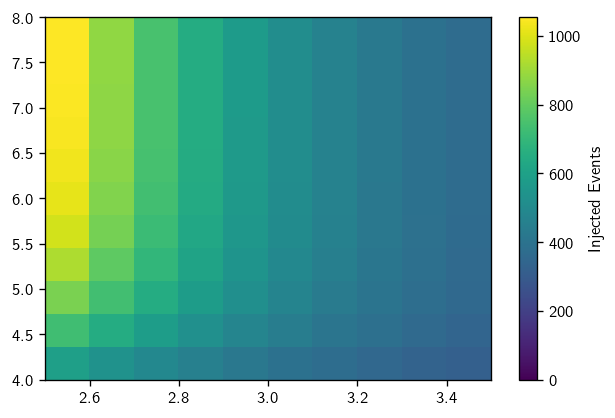

In [40]:
fig, ax = plt.subplots()
gamma, cutoff = np.meshgrid( fit_gammas, np.log10(fit_cutoffs),)
plt.pcolormesh(gamma, cutoff, injs.T,
           cmap='viridis',vmin=0)
plt.colorbar(label='Injected Events')


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


Text(0.5, 1.0, 'Inj Flux: GP')

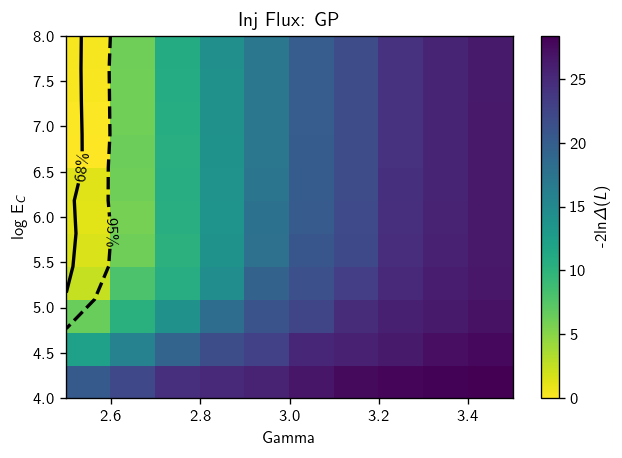

In [37]:
fig, ax = plt.subplots()
gamma, cutoff = np.meshgrid( fit_gammas, np.log10(fit_cutoffs),)
delta_t = -(trials - np.max(trials))
plt.pcolormesh(gamma, cutoff, delta_t.T,
           cmap='viridis_r')

gamma, cutoff = np.meshgrid( fit_gammas, np.log10(fit_cutoffs),)
contour_fracs = [0.68, .95]
dLLHs = stats.chi2.ppf (contour_fracs, 2)
contour_labels = {dLLH: r'{:.0f}$\%$'.format (100*frac) for (dLLH, frac) in zip (dLLHs, contour_fracs)}

plt.colorbar(label='-2ln$\Delta$($L$)')

cont = plt.contour(fit_gammas, np.log10(fit_cutoffs), delta_t.T, dLLHs, colors='k', linestyles=['solid', 'dashed'])
ax.clabel (cont, inline=True, fmt=contour_labels, fontsize=10, inline_spacing=1)
plt.xlabel('Gamma')
plt.ylabel('log E$_{C}$ ')
plt.title('Inj Flux: GP')